In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("TITANIC SURVIVAL PREDICTION - MACHINE LEARNING PROJECT")
print("=" * 80)

TITANIC SURVIVAL PREDICTION - MACHINE LEARNING PROJECT


In [3]:
print("\n[STEP 1] Loading Dataset...")

# Load the training data
# Download from: https://www.kaggle.com/competitions/titanic/data
# Place 'train.csv' in the same directory as this notebook
try:
    df = pd.read_csv('train.csv')
    print(f"✓ Dataset loaded successfully!")
    print(f"  Shape: {df.shape}")
    print(f"  Rows: {df.shape[0]}, Columns: {df.shape[1]}")
except FileNotFoundError:
    print("ERROR: 'train.csv' not found!")
    print("Please download the dataset from Kaggle and place it in the current directory.")
    raise


[STEP 1] Loading Dataset...
✓ Dataset loaded successfully!
  Shape: (891, 12)
  Rows: 891, Columns: 12


In [4]:
print("\n[STEP 2] Exploratory Data Analysis...")

# Display basic information
print("\n--- Dataset Overview ---")
print(df.head())

print("\n--- Dataset Information ---")
print(df.info())

print("\n--- Statistical Summary ---")
print(df.describe())

print("\n--- Missing Values ---")
missing = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_table[missing_table['Missing Count'] > 0])

print("\n--- Survival Rate ---")
survival_rate = df['Survived'].value_counts(normalize=True) * 100
print(f"Survived: {survival_rate[1]:.2f}%")
print(f"Did not survive: {survival_rate[0]:.2f}%")


[STEP 2] Exploratory Data Analysis...

--- Dataset Overview ---
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123  


[STEP 3] Creating Visualizations...


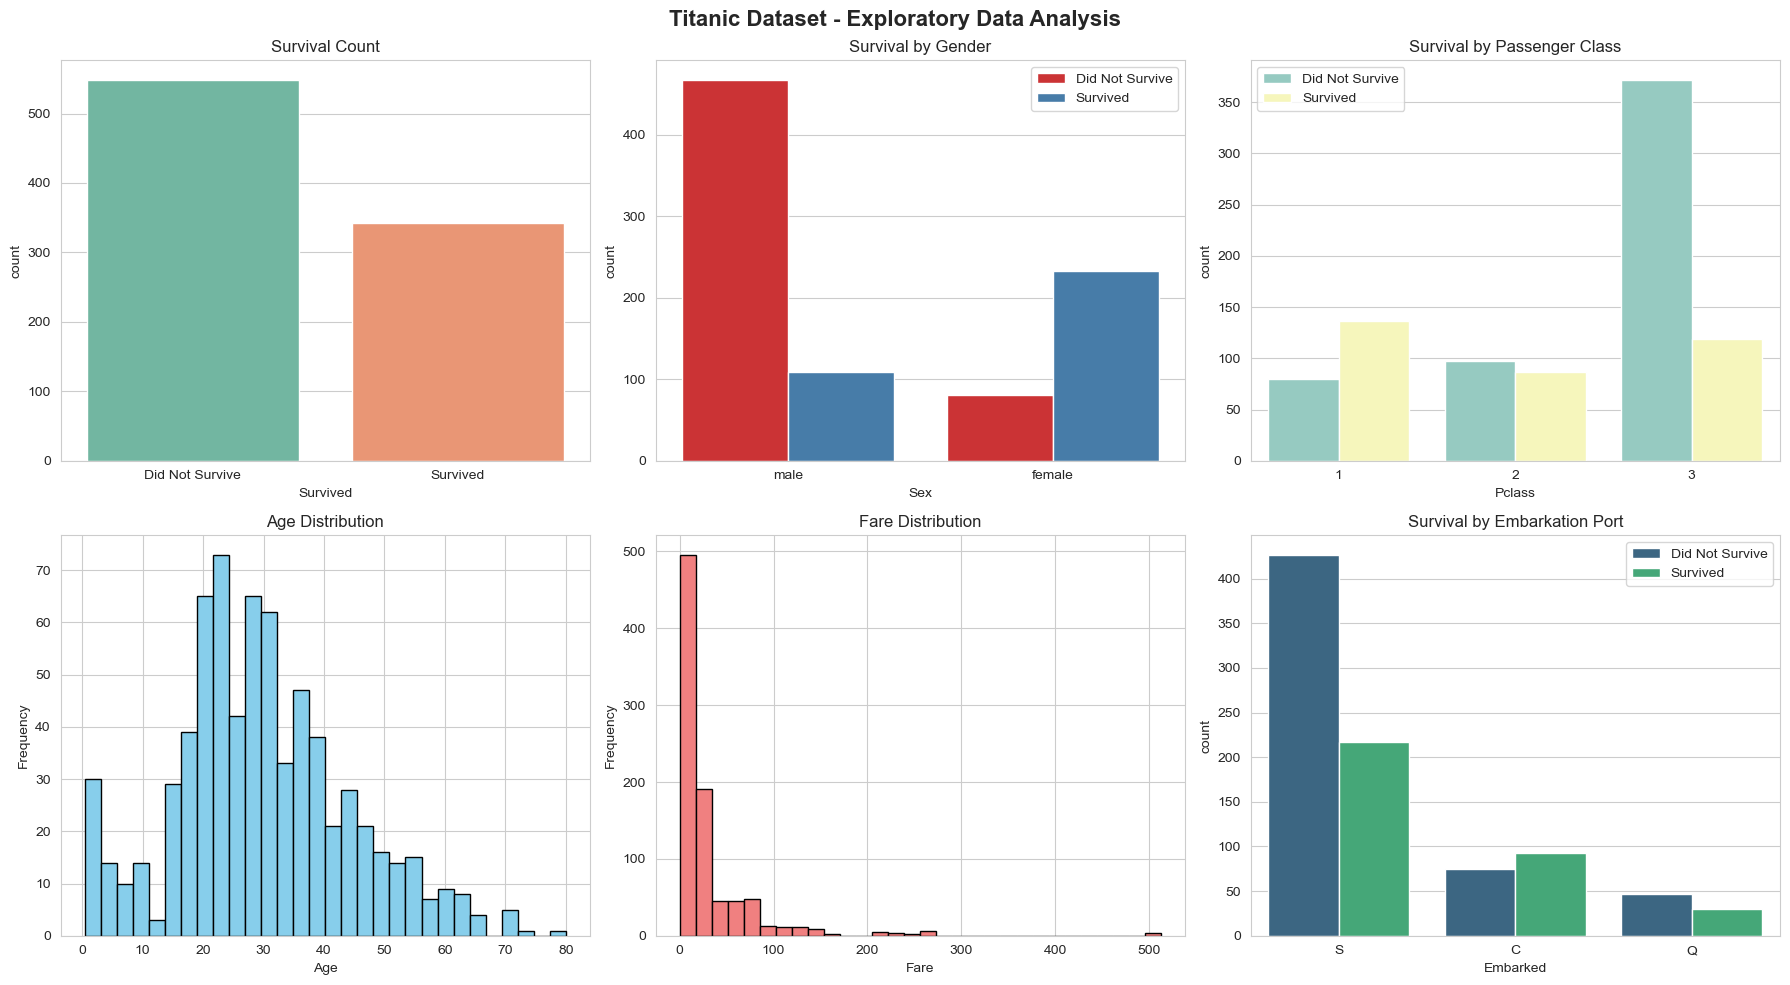


--- Creating Correlation Heatmap ---


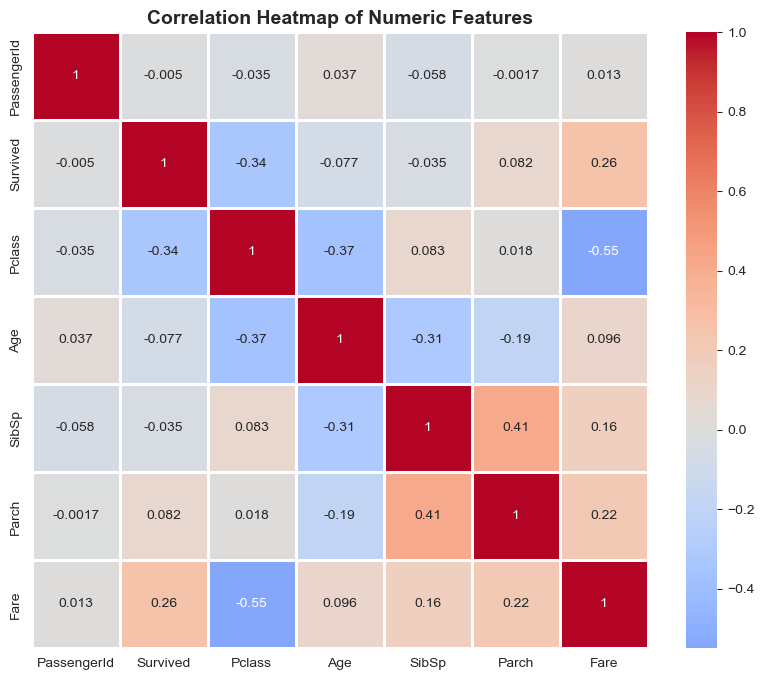

In [5]:
print("\n[STEP 3] Creating Visualizations...")

# Create subplots for visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Titanic Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Survival Count
sns.countplot(data=df, x='Survived', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Survival Count')
axes[0, 0].set_xticklabels(['Did Not Survive', 'Survived'])

# 2. Survival by Gender
sns.countplot(data=df, x='Sex', hue='Survived', ax=axes[0, 1], palette='Set1')
axes[0, 1].set_title('Survival by Gender')
axes[0, 1].legend(['Did Not Survive', 'Survived'])

# 3. Survival by Class
sns.countplot(data=df, x='Pclass', hue='Survived', ax=axes[0, 2], palette='Set3')
axes[0, 2].set_title('Survival by Passenger Class')
axes[0, 2].legend(['Did Not Survive', 'Survived'])

# 4. Age Distribution
df['Age'].dropna().hist(bins=30, ax=axes[1, 0], color='skyblue', edgecolor='black')
axes[1, 0].set_title('Age Distribution')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Frequency')

# 5. Fare Distribution
df['Fare'].hist(bins=30, ax=axes[1, 1], color='lightcoral', edgecolor='black')
axes[1, 1].set_title('Fare Distribution')
axes[1, 1].set_xlabel('Fare')
axes[1, 1].set_ylabel('Frequency')

# 6. Survival by Embarked
sns.countplot(data=df, x='Embarked', hue='Survived', ax=axes[1, 2], palette='viridis')
axes[1, 2].set_title('Survival by Embarkation Port')
axes[1, 2].legend(['Did Not Survive', 'Survived'])

plt.tight_layout()
plt.show()

# Correlation Heatmap
print("\n--- Creating Correlation Heatmap ---")
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1)
plt.title('Correlation Heatmap of Numeric Features', fontsize=14, fontweight='bold')
plt.show()

In [6]:
print("\n[STEP 4] Data Preprocessing...")

# Create a copy for preprocessing
data = df.copy()

# Handle missing values
print("\n--- Handling Missing Values ---")

# Age: Fill with median age by Pclass and Sex
data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

# Embarked: Fill with mode
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Cabin: Create a binary feature (has cabin or not)
data['Has_Cabin'] = data['Cabin'].notna().astype(int)

# Fare: Fill with median
data['Fare'].fillna(data['Fare'].median(), inplace=True)

print("✓ Missing values handled")

# Feature Engineering
print("\n--- Feature Engineering ---")

# Family Size
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# Is Alone
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Age Groups
data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 12, 18, 35, 60, 100], 
                          labels=['Child', 'Teen', 'Adult', 'Middle_Age', 'Senior'])

# Fare Groups
data['FareGroup'] = pd.qcut(data['Fare'], q=4, 
                            labels=['Low', 'Medium', 'High', 'Very_High'])

# Title Extraction from Name
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                       'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

print("✓ Feature engineering completed")

# Encode Categorical Variables
print("\n--- Encoding Categorical Variables ---")

# Label Encoding
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
data['Embarked'] = le.fit_transform(data['Embarked'])
data['Title'] = le.fit_transform(data['Title'])
data['AgeGroup'] = le.fit_transform(data['AgeGroup'])
data['FareGroup'] = le.fit_transform(data['FareGroup'])

print("✓ Categorical variables encoded")

# Select Features
features_to_use = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 
                   'FamilySize', 'IsAlone', 'Has_Cabin', 'Title',
                   'AgeGroup', 'FareGroup']

X = data[features_to_use]
y = data['Survived']

print(f"\n--- Selected Features ({len(features_to_use)}) ---")
print(features_to_use)


[STEP 4] Data Preprocessing...

--- Handling Missing Values ---
✓ Missing values handled

--- Feature Engineering ---
✓ Feature engineering completed

--- Encoding Categorical Variables ---
✓ Categorical variables encoded

--- Selected Features (11) ---
['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Has_Cabin', 'Title', 'AgeGroup', 'FareGroup']


In [7]:
print("\n[STEP 5] Splitting Data...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Data scaled using StandardScaler")


[STEP 5] Splitting Data...
Training set: (712, 11)
Testing set: (179, 11)
✓ Data scaled using StandardScaler


In [8]:
print("\n[STEP 6] Training Multiple ML Models...")
print("=" * 80)

# Dictionary to store models and results
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

results = []

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    cv_mean = cv_scores.mean()
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Score': cv_mean
    })
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Cross-Validation Score: {cv_mean:.4f}")

# Results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "=" * 80)
print("MODEL COMPARISON RESULTS")
print("=" * 80)
print(results_df.to_string(index=False))


[STEP 6] Training Multiple ML Models...

--- Training Logistic Regression ---
Accuracy: 0.8045
Precision: 0.7576
Recall: 0.7246
F1-Score: 0.7407
Cross-Validation Score: 0.8034

--- Training Decision Tree ---
Accuracy: 0.7654
Precision: 0.7213
Recall: 0.6377
F1-Score: 0.6769
Cross-Validation Score: 0.7501

--- Training Random Forest ---
Accuracy: 0.7877
Precision: 0.7246
Recall: 0.7246
F1-Score: 0.7246
Cross-Validation Score: 0.7978

--- Training Gradient Boosting ---
Accuracy: 0.7821
Precision: 0.7586
Recall: 0.6377
F1-Score: 0.6929
Cross-Validation Score: 0.8189

--- Training Support Vector Machine ---
Accuracy: 0.8212
Precision: 0.7761
Recall: 0.7536
F1-Score: 0.7647
Cross-Validation Score: 0.8175

--- Training Naive Bayes ---
Accuracy: 0.7542
Precision: 0.6712
Recall: 0.7101
F1-Score: 0.6901
Cross-Validation Score: 0.7739

--- Training K-Nearest Neighbors ---
Accuracy: 0.7989
Precision: 0.7619
Recall: 0.6957
F1-Score: 0.7273
Cross-Validation Score: 0.7823

MODEL COMPARISON RESULTS


In [9]:
print("\n[STEP 7] Hyperparameter Tuning for Best Models...")

# Tune Random Forest (usually performs best)
print("\n--- Tuning Random Forest ---")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                       rf_params, cv=5, n_jobs=-1, verbose=0)
rf_grid.fit(X_train_scaled, y_train)

print(f"Best Parameters: {rf_grid.best_params_}")
print(f"Best CV Score: {rf_grid.best_score_:.4f}")

best_model = rf_grid.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

print("\n--- Best Model Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_best, 
                          target_names=['Did Not Survive', 'Survived']))


[STEP 7] Hyperparameter Tuning for Best Models...

--- Tuning Random Forest ---
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best CV Score: 0.8287

--- Best Model Performance ---
Accuracy: 0.8268

Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.85      0.87      0.86       110
       Survived       0.79      0.75      0.77        69

       accuracy                           0.83       179
      macro avg       0.82      0.81      0.82       179
   weighted avg       0.83      0.83      0.83       179




[STEP 8] Creating Final Visualizations...


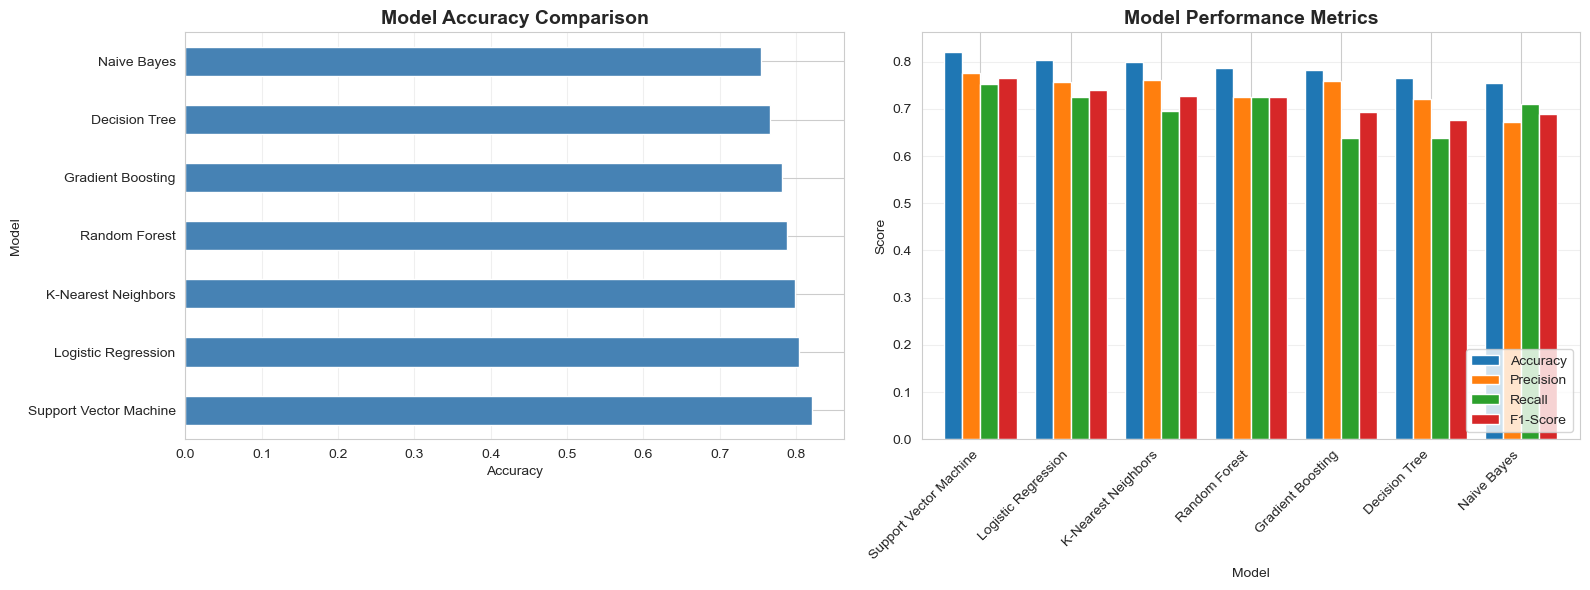

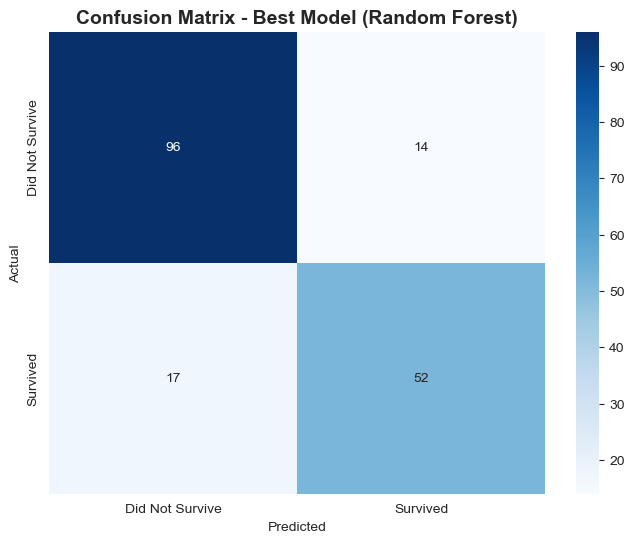

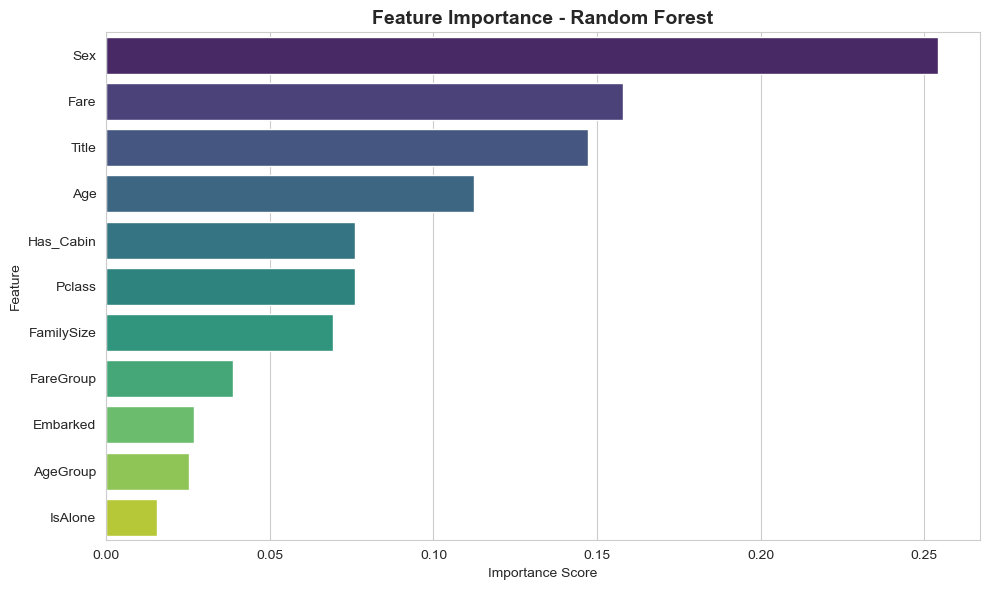


PROJECT COMPLETED SUCCESSFULLY!

Best Model: Random Forest Classifier
Final Test Accuracy: 0.8268

Key Insights:
1. Most important features: Sex, Fare, Title
2. Overall survival rate: 38.38%
3. Female survival rate: 74.20%
4. Male survival rate: 18.89%
5. First class survival rate: 62.96%


In [10]:
print("\n[STEP 8] Creating Final Visualizations...")

# Model Comparison Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy Comparison
results_df.plot(x='Model', y='Accuracy', kind='barh', ax=axes[0], 
                color='steelblue', legend=False)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Accuracy')
axes[0].grid(axis='x', alpha=0.3)

# Multiple Metrics Comparison
metrics_df = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_df.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_xlabel('Model')
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.title('Confusion Matrix - Best Model (Random Forest)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features_to_use,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 80)
print(f"\nBest Model: Random Forest Classifier")
print(f"Final Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"\nKey Insights:")
print(f"1. Most important features: {', '.join(feature_importance.head(3)['Feature'].values)}")
print(f"2. Overall survival rate: {df['Survived'].mean()*100:.2f}%")
print(f"3. Female survival rate: {df[df['Sex']=='female']['Survived'].mean()*100:.2f}%")
print(f"4. Male survival rate: {df[df['Sex']=='male']['Survived'].mean()*100:.2f}%")
print(f"5. First class survival rate: {df[df['Pclass']==1]['Survived'].mean()*100:.2f}%")